# Transfer Learning & Fine Tuning 

## Ce que vous apprendrez dans ce cours

Une faculté précieuse du Deep Learning est celle de pouvoir s'adapter à plusieurs situations différentes via le _Transfer Learning_. Le principe est simple, au lieu de construire une architecture de réseaux de neurones from scratch, nous allons utiliser des architectures pré-faites et pré-entrainées. Cette technique permet d'atteindre des résultats de performances _state of the art_. 

Ce cours vise donc à montrer comment effectuer du _Transfer Learning_ sur Tensorflow 2.0. Nous utiliserons ceci pour de la reconnaissance d'images sur des types de fleurs contenues dans un dossier *flower_photos*.

## Chargement du dataset & preprocessing 

### Téléchargement des images depuis des chemins

In [2]:
#!pip install tensorflow-gpu==2.0.0beta1
import tensorflow as tf

Nous allons utiliser la méthode *get_file* du module *tf.keras.utils* pour télécharger des données publiques contenues dans Google Cloud Storage que nous stockerons ensuite dans une dossier *flower_photos*

In [3]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='/content/flower_photos.tgz', 
                                         untar=True,
                                         cache_subdir="/content")
data_root = pathlib.Path("/content/flower_photos")
print(data_root)

228818944/228813984 [==============================] - 2s 0us/step
/content/flower_photos


Dans le code du dessus,  nous spécifions les paramètres suivants : 

* `origin`: l'url vers lequel est contenu les données 
* `fname`: est le nom du fichier que vous souhaitez télécharger. Vous pouvez aussi spécifier le chemin dans lequel le fichier doit être stocké.
* `untar`: Ceci permet de décompresser les fichiers automatiquement 
* `cache_subdir`: Cela spécifier le sous-dossier dans lequel doit être contenu les données décompressées 

Regardons maintenant chacun des fichiers contenus dans le dossier. 

In [6]:
for item in data_root.iterdir():
  print(item)

/content/flower_photos/dandelion
/content/flower_photos/LICENSE.txt
/content/flower_photos/tulips
/content/flower_photos/daisy
/content/flower_photos/sunflowers
/content/flower_photos/roses


Regardons maintenant quelques images. Pour cela nous allons utiliser la librairie `tf.image` qui va nous permettre de regarder chacune des images et de faire un peu de preprocessing. 

In [7]:
# Ce code va lister toutes les images contenues dans tous les dossiers contenus dans 
# le dossier racine de data_root qu'on a spécifié plus haut: "/content/flower_photos"
all_images = list(data_root.glob("*/*"))

In [9]:
# Questions annexes Bonus, pas utilisé après mais pour bien comprendre comment
# récupérer des path (chemins d'accès) avec la librairie pathlib 

# On liste tous les fichiers ou dossiers contenus dans '/content/flower_photos'
x1 = list(data_root.glob("*"))

# On liste UNIQUEMENT les dossiers contenus dans '/content/flower_photos'
x2 = [x for x in data_root.glob("*") if x.is_dir()]

# On liste tous les fichiers contenus dans '/content/flower_photos/daisy'
x3 = [x for x in data_root.glob("daisy/*") if not x.is_dir()]

In [10]:
# On vérifie qu'on a bien récupéré des path vers des images
all_images[0]

PosixPath('/content/flower_photos/dandelion/14761980161_2d6dbaa4bb_m.jpg')

In [11]:
# On récupère tous les path au format string, pour cela on utilise la fonction str()
# sur les PosixPath retournés par data_root.glob("*/*")
all_image_paths = [str(path) for path in data_root.glob("*/*")]

In [12]:
all_image_paths[:10]

['/content/flower_photos/dandelion/14761980161_2d6dbaa4bb_m.jpg',
 '/content/flower_photos/dandelion/8058286066_acdf082487_n.jpg',
 '/content/flower_photos/dandelion/16949657389_ac0ee80fd1_m.jpg',
 '/content/flower_photos/dandelion/17649230811_9bdbbacb8c.jpg',
 '/content/flower_photos/dandelion/17344936845_fec4d626b7.jpg',
 '/content/flower_photos/dandelion/8759118120_9eac064e38_n.jpg',
 '/content/flower_photos/dandelion/13887066460_64156a9021.jpg',
 '/content/flower_photos/dandelion/2502610598_b9f1b55ebd_n.jpg',
 '/content/flower_photos/dandelion/98992760_53ed1d26a9.jpg',
 '/content/flower_photos/dandelion/8724252904_db9a5104df_m.jpg']

In [13]:
# On va lire chacun de ces path en utilisant la fonction tf.io.read_file
# Le résultat est une suite de bytes qu'il va falloir convertir en image
all_tensors_images_in_bytes = [tf.io.read_file(path) for path in all_image_paths]

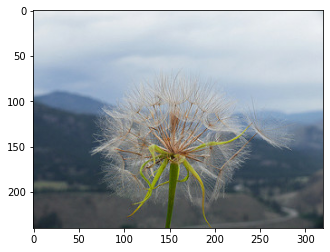

In [15]:
import numpy as np
import matplotlib.pyplot as plt 

# On prend une suite de bytes aléatoire (qui correspond à une image tirée aléatoirement)
random_img_in_bytes = all_tensors_images_in_bytes[np.random.randint(100)]

# On décode cette suite de bytes en image
random_img = tf.image.decode_jpeg(random_img_in_bytes)

# On plotte l'image après avoir convertit random_img au format numpy (random_img est un tenseur)
plt.imshow(random_img.numpy())

### La méthode .map

Nous allons résumer tout ce que nous venons de faire dans une fonction preprocess_and_load_images qui va lire les images, les décoder et les resize

1. Nous allons créer une fonction qui va lire les images et les mettre à la bonne taille.
2. Nous créerons une instance de `tf.data` c.a.d un objet dataset qui va faire l'interface entre nos données stockées sur le disque et le modèle.

In [16]:
# Création d'une fonction qui lit le chemin d'une image,
# décode l'image puis lui change sa taille.
def preprocess_and_load_images(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  return image

In [17]:
# Création d'une instance de Tf.data
ds_paths = tf.data.Dataset.from_tensor_slices(all_image_paths)
ds_images = ds_paths.map(preprocess_and_load_images)

On utilise la méthode map qui va appliquer la fonction preprocess_and_load_images à chaque image du dataset

Cette méthode est extrêmement pratique et s'utilise beaucoup dans l'univers Tensorflow. Plus d'informations ici : 

[map function](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)

In [18]:
# Regardons quelques exemples de notre dataset pour voir si tout est bon
for i,example in enumerate(ds_images):
  if i < 3:
    print(example)
  else:
    break

tf.Tensor(
[[[ 0.        2.25      0.      ]
  [ 0.        2.25      0.      ]
  [ 0.        2.25      0.      ]
  ...
  [ 0.        4.        0.      ]
  [ 0.        4.        0.      ]
  [ 0.        4.        0.      ]]

 [[ 0.        4.375     0.      ]
  [ 0.        4.375     0.      ]
  [ 0.        4.375     0.      ]
  ...
  [ 0.        4.        0.      ]
  [ 0.        4.        0.      ]
  [ 0.        4.        0.      ]]

 [[ 0.        4.375     0.      ]
  [ 0.        4.375     0.      ]
  [ 0.        4.375     0.      ]
  ...
  [ 0.        4.        0.      ]
  [ 0.        4.        0.      ]
  [ 0.        4.        0.      ]]

 ...

 [[40.       50.        0.      ]
  [40.       50.        0.      ]
  [40.       50.        0.      ]
  ...
  [48.981445 58.820312  0.      ]
  [48.367188 57.992188  0.      ]
  [47.625    57.25      0.      ]]

 [[39.375    49.375     0.      ]
  [39.375    49.375     0.      ]
  [39.375    49.375     0.      ]
  ...
  [47.375    56.588867  0. 

### Gestion des labels depuis un dossier 

Chaque image se trouve dans un sous-dossier du dossier `flower_photos`. Le nom du dossier dans lequel se trouve l'image est le nom de la classe de l'image, on va donc lister toutes les images présentes dans le dossier flower_photos, dans le même ordre qu'on a lisé les images pour générer les données d'entraînement. On va récupérer le label associé à chaque image en récupérant le nom du dossier dans lequel elle se trouve : 

In [19]:
labels = []
labels =[data.name for data in data_root.iterdir() if data.is_dir()]
# Boucle sur tous les éléments du dossier flower_photos
# Vérifie que l'élément soit un dossier
# On ne prend que le nom du dossier 

In [20]:
print(labels)

['dandelion', 'tulips', 'daisy', 'sunflowers', 'roses']


Une fois que nous avons les éléments du dossier, nous allons leur donner un index afin que nous ayons avoir des labels chiffrés: On doit fournir les labels sous forme d'entiers à un modèle Tensorflow 

In [21]:
labels_index = {}
for i,label in enumerate(labels):
  labels_index[label]=i
  
print(labels_index)  

{'dandelion': 0, 'tulips': 1, 'daisy': 2, 'sunflowers': 3, 'roses': 4}


Enfin, nous devons créer une liste de la taille de notre dataset qui va donner le label de chacune des photos. 

In [23]:
all_image_labels = [labels_index[path.parent.name] for path in list(data_root.glob("*/*"))]

In [24]:
len(all_image_labels) == len(all_images)

True

Nous avons généré la liste des labels associée aux images de notre dataset. Vérifions que l'on ne s'est pas trompé sur une image. 

Text(0.5, 1.0, "index = 4, flower_name = ['roses']")

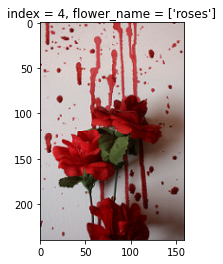

In [27]:
random_image = np.random.randint(len(all_image_labels))

plt.imshow(tf.image.decode_jpeg(all_tensors_images_in_bytes[random_image]).numpy())

plt.title("index = {}, flower_name = {}".format(all_image_labels[random_image], 
                                                [key for key, value in labels_index.items() if value == all_image_labels[random_image]]))

Il semblerait que tout soit bon ! On va donc pouvoir créer un dataset qui va mélanger les images ainsi que les labels 

In [28]:
# Nous créons un dataset pour nos labels 
labels_ds = tf.data.Dataset.from_tensor_slices(all_image_labels)

In [29]:
# Nous créons un dataset qui zip les deux datasets
# C.a.d qu'il apparie les éléments de ds_images et labels_ds situés aux mêmes index
full_ds = tf.data.Dataset.zip((ds_images, labels_ds))

Regardons la tête de notre nouveau dataset :

In [33]:
x = next(iter(full_ds))
print(type(x))


<class 'tuple'>


Nous voyons bien que nous avons notre dataset avec les labels correspondant ! On est donc très bien parti pour lancer notre modèle. 

Passons maintenant à la partie Data Augmentation 

### Data Augmentation 

Cette fois, nous n'allons pas faire notre data augmentation sur des objets Numpy mais directement sur les images présentes dans le dossier *flower_photos*. 

Au lieu de passer par Keras, nous allons cette fois reprendre la méthode que nous avons utilisé plus haut avec la fonction `map`. Nous allons donc créer une fonction `augmentation` qui fera tout le travail d'augmentation puis nous maperons ceci sur nos données. 

In [34]:
def augmentation(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_crop(image, size=(192,192, 3))
  image = tf.image.random_brightness(image, max_delta=10)
  image = image /255.0

  return image, label

Dans la fonction d'augmentation, nous effectuons : 

1. Un effet mirroir horizontal sur les images 
2. Un rognage aléatoire 
3. Une différence de luminosité aléatoire 

Appliquons les sur notre dataset 

In [ ]:
full_ds = full_ds.map(augmentation)

On mélange toutes les images puis on transforme le dataset pour qu'il nous retourne des batchs. 

Cela permettra à notre modèle de voir des images différentes par batch au lieu de voir chacun des labels de manière séquentielle. 

In [35]:
full_ds = full_ds.shuffle(len(all_images)).batch(10)

Regardons maintenant une image dans 3 batch différents. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


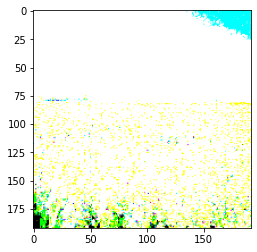

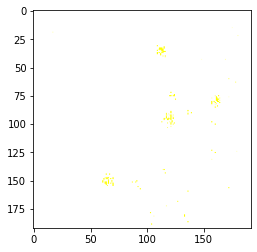

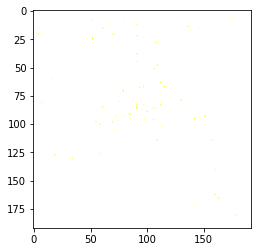

In [36]:
for example_x, example_y in full_ds.take(3):
  plt.figure()
  plt.imshow(example_x[0].numpy())
  
plt.show()  

## Transfer Learning 

### Import d'un modèle pré-entrainé 

Plutôt que de construire un modèle from scratch on va utiliser un modèle CNN déjà existant : Inception_v3 et l'utiliser pour classer nos fleurs. Voici comment nous pouvons procéder

In [41]:
base_model = tf.keras.applications.InceptionV3(input_shape=(192,192,3), 
                                               include_top=False, # Ici on ne prend pas la couche de sortie
                                               weights = "imagenet" # On prend un modèle pré-entraîné sur la base de données imagenet ici
                                               )

#base_model_2 = tf.keras.applications.InceptionV3( include_top=True, # Ici on ne prend pas la couche de sortie
#                                               weights = "imagenet" # On prend un modèle pré-entraîné sur la base de données imagenet ici
#                                               )

96116736/96112376 [==============================] - 1s 0us/step


Ici, nous avons importé l'architecture à laquelle nous avons spécifié de na pas prendre la dernière couche d'output. En effet, cette couche sera adaptée à notre besoin de classification de fleurs. Ce modèle a été entrainé sur un nombre beaucoup plus conséquents d'images différentes. 

Regardons rapidement ce que donne l'architecture de notre modèle :

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

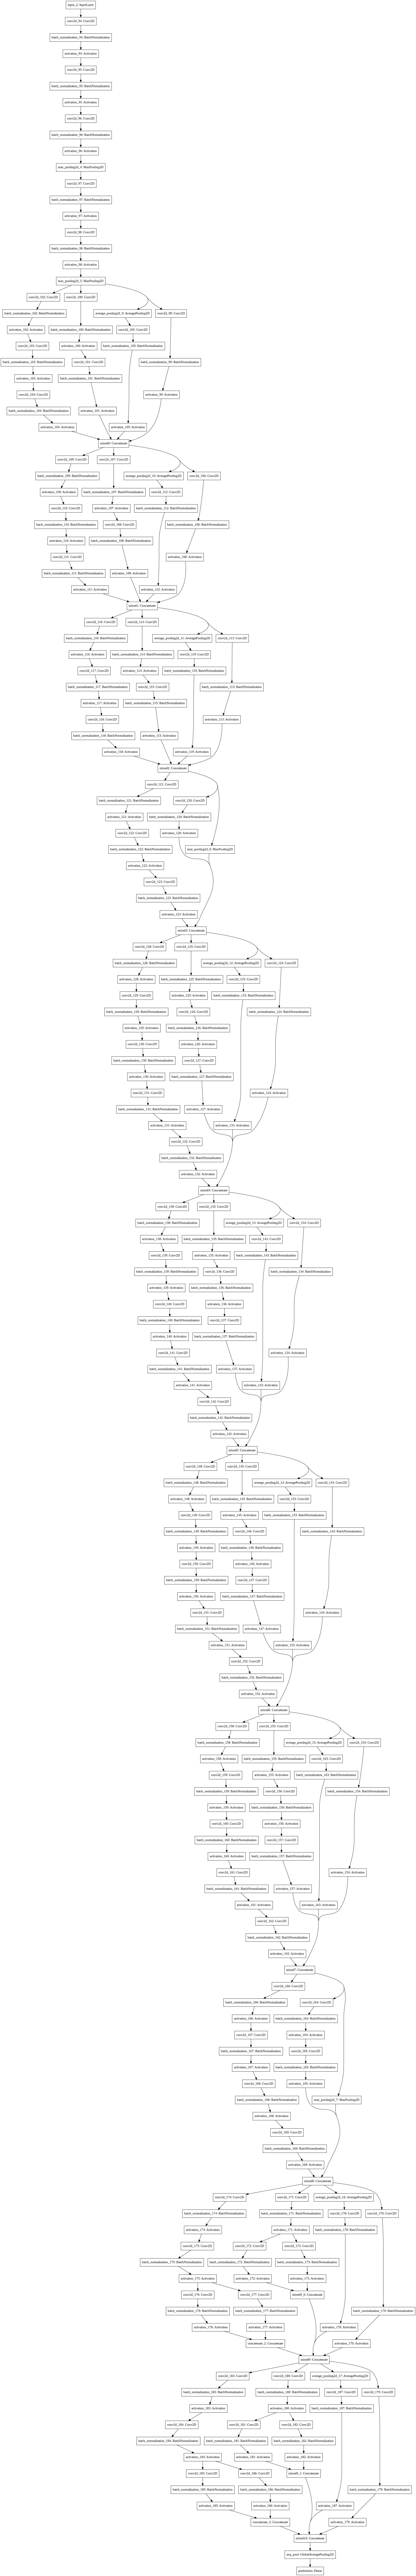

In [42]:
base_model.summary()

tf.keras.utils.plot_model(base_model)

Nous devons maintenant geler notre modèle pour n'entrainer que les dernières couches

In [ ]:
base_model.trainable = False

Ceci empêche d'entrainer tout notre modèle. Ajoutons maintenant la dernière couche qui nous intéresse pour notre problématique 

### Adaptation du modèle au dataset

Lorsque nous avons importé notre modèle, nous avons enlevé la dernière couche pour pouvoir l'adapter à notre situation. Prenons donc maintenant la prochaine cellule de code pour ajouter notre dernière couche. 



On constate que les dernières couches de base_model sont plusieurs couches de convolution concaténées, leur concaténation est un tenseur de shape (None, 4, 4, 2048). On se rappelle que les dimensions des réseaux pour les images sont: (batch_size, longueur_image, largeur_image, nb_channels) => Ici nb_channels = 2048, cela signifie que les couches de convolution précédentes ont output 2048 images en tout.



Nous allons utiliser une couche `GlobalAveragePooling2D` qui va permettre de sortir les pixels les plus signifiants de l'image et une dernière couche `Dense` qui prendra le nombre de classes de notre dataset et une fonction d'activation `softmax` qui sortira des probabilités pour chacune des prédictions. 

In [45]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(labels), activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


Préparons notre fonction de coût, notre optimiser et un learning rate schedule pour améliorer nos résultats de prédictions et minimiser notre fonction de coût. 

In [43]:
# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

Entrainons maintenant notre modèle.

In [47]:
model.fit(full_ds, epochs=5)

Epoch 1/5
367/367 [==============================] - 26s 72ms/step - loss: 0.9621 - sparse_categorical_accuracy: 0.6561
Epoch 2/5
367/367 [==============================] - 27s 74ms/step - loss: 0.7519 - sparse_categorical_accuracy: 0.7278
Epoch 3/5
367/367 [==============================] - 28s 75ms/step - loss: 0.6841 - sparse_categorical_accuracy: 0.7493
Epoch 4/5
367/367 [==============================] - 28s 76ms/step - loss: 0.6223 - sparse_categorical_accuracy: 0.7757
Epoch 5/5
367/367 [==============================] - 28s 76ms/step - loss: 0.4993 - sparse_categorical_accuracy: 0.8161


Nos résultats ne sont pas mauvais déjà ! Nous pouvons cependant tenter de continuer d'entrainer notre modèle mais cette fois en libérant quelque couche. C'est ce qu'on appelle faire du _fine tuning_. Nous allons donc débloquer les 75 dernières couches du modèle. 

In [48]:
base_model.trainable = True
fine_tune_at = 75
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Retentons d'entrainer le modèle. 

In [49]:
# Vous devrez refaire tourner un model.compile avant de ré-entrainer le modèle 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

model.fit(full_ds, epochs=15)

Epoch 1/15
367/367 [==============================] - 20s 56ms/step - loss: 0.4639 - sparse_categorical_accuracy: 0.8362
Epoch 2/15
367/367 [==============================] - 21s 57ms/step - loss: 0.3633 - sparse_categorical_accuracy: 0.8678
Epoch 3/15
367/367 [==============================] - 21s 57ms/step - loss: 0.3254 - sparse_categorical_accuracy: 0.8905
Epoch 4/15
367/367 [==============================] - 21s 58ms/step - loss: 0.2336 - sparse_categorical_accuracy: 0.9193
Epoch 5/15
367/367 [==============================] - 21s 58ms/step - loss: 0.1815 - sparse_categorical_accuracy: 0.9349
Epoch 6/15
367/367 [==============================] - 21s 58ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.9425
Epoch 7/15
367/367 [==============================] - 21s 58ms/step - loss: 0.1403 - sparse_categorical_accuracy: 0.9561
Epoch 8/15
367/367 [==============================] - 21s 58ms/step - loss: 0.1271 - sparse_categorical_accuracy: 0.9583
Epoch 9/15
367/367 [============

KeyboardInterrupt: ignored

Nous arrivons à des résultats très satisfaisants ! Nous n'avons pas de dataset de validation donc il nous sera difficile de vérifier l'overfitting. Regardons cependant une prédiction sur un batch de données d'entrainement.

In [ ]:
# nous créons une liste de prédictions pour tout le dataset 
y_pred = [np.argmax(model.predict_on_batch(pred),1) for pred in full_ds.take(-1)]

In [ ]:
# Convertissons chacune des prédictions en listes plutôt qu'en numpy array
y_pred = [list(y) for y in y_pred]

In [ ]:
# Visualisons les 10 images du batch 
for x, y in full_ds.take(1):
  for i in range(len(y)):
    plt.figure()
    plt.imshow(x.numpy()[i])
    plt.title("true : {}\n pred : {}".format(y.numpy()[i], y_pred[0][i]))
plt.show()

Sur les 10 images de ce batch, nous avons 1 seule erreur. Les résultats sont donc très satisfaisants ! 

## Visualiser le processus d'apprentissage

Pour visualiser le processus d'apprentissage, il vous faudra stocker l'apprentissage de votre modèle dans une variable 

In [ ]:
history = model.fit(full_ds, epochs=5)

Epoch 1/5
367/367 [==============================] - 104s 282ms/step - loss: 0.0544 - sparse_categorical_accuracy: 0.9807
Epoch 2/5
367/367 [==============================] - 103s 281ms/step - loss: 0.0643 - sparse_categorical_accuracy: 0.9779
Epoch 3/5
367/367 [==============================] - 103s 280ms/step - loss: 0.0295 - sparse_categorical_accuracy: 0.9896
Epoch 4/5
367/367 [==============================] - 102s 278ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9864
Epoch 5/5
367/367 [==============================] - 102s 279ms/step - loss: 0.1119 - sparse_categorical_accuracy: 0.9597


Une fois ceci fait, vous obtenez à l'intérieur de _history_ un dictionnaire de valeur que vous pouvez accéder de la façon suivante : 

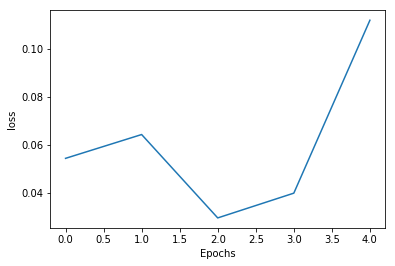

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

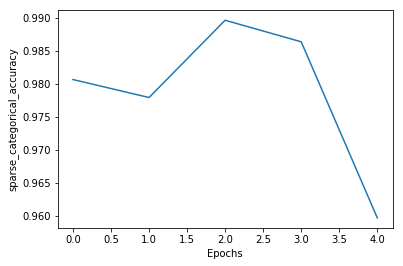

In [ ]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.ylabel("sparse_categorical_accuracy")
plt.xlabel("Epochs")
plt.show()

## Ressources

* [Load Images with Tf.Data](https://www.tensorflow.org/beta/tutorials/load_data/images)
* [Transfer Learning using pre-trained ConvNets](https://www.tensorflow.org/beta/tutorials/images/transfer_learning)
* [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)